#Data Loading

In [32]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import gzip
import shutil

In [33]:
'Functions'

def preprocess_nifti_data(data_folder):
    """
    Processes all .nii.gz files in a folder by extracting, loading, rotating,
    and concatenating them into a single volume.

    Parameters:
        data_folder (str): Path to the folder containing .nii.gz files.

    Returns:
        numpy.ndarray: The final 4D array of shape (Nx, Ny, Nz * num_files, t).
    """
    volumes = []

    # List all .nii.gz files in the folder
    nii_gz_files = [f for f in os.listdir(data_folder) if f.endswith('.nii.gz')]

    for file in nii_gz_files:
        file_path = os.path.join(data_folder, file)
        extracted_path = file_path[:-3]  # Remove ".gz" to get ".nii" path

        # Extract the .nii file from .nii.gz
        with gzip.open(file_path, 'rb') as f_in, open(extracted_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

        # Load the extracted .nii file
        nii = nib.load(extracted_path)
        data = nii.get_fdata()

        # Rotate 90 degrees counterclockwise in the xy-plane
        rotated_data = np.rot90(data, k=1, axes=(0, 1))

        # Append to list
        volumes.append(rotated_data)

        # Delete the extracted .nii file after loading
        os.remove(extracted_path)

    # Concatenate along the z-axis
    final_data = np.concatenate(volumes, axis=2)

    print(f"Final shape of ground truth: {final_data.shape}; dimensions: (Nx, Ny, Nz*Nvol, t)")
    return final_data


def add_gaussian_noise(data, noise_level):
    """
    Adds Gaussian noise to each slice and timeframe in the dataset with a different noise level per slice and timeframe.

    Parameters:
        data (numpy.ndarray): The full dataset of shape (Nx, Ny, Nz*Nvol, t).
        noise_level (float): Maximum fraction of image intensity to use as noise (between 0 and 1).

    Returns:
        numpy.ndarray: The noisy dataset with the same shape as the input.
    """
    noisy_data = np.zeros_like(data)

    # Iterate over time dimension
    for t in range(data.shape[-1]):
        for z in range(data.shape[2]):  # Iterate over slices in the 3rd dimension
            # Compute slice-specific noise level as a fraction of its max intensity
            max_intensity = np.max(data[:, :, z, t])
            noise_std = np.random.uniform(0, noise_level) * max_intensity  # Scale noise

            # Add Gaussian noise to this slice
            noise = np.random.normal(0, noise_std, data[:, :, z, t].shape)
            noisy_data[:, :, z, t] = data[:, :, z, t] + noise

    print(f"Final shape of noisy dataset: {noisy_data.shape}; dimensions: (Nx, Ny, Nz*Nvol, t)")

    return noisy_data


def get_run_and_slice(slice_index, slices_per_run=39):
    """
    Input slice index from total data volume and return specific run and corresponding slice within run.

    Paramters:
        slice_index: Slice index from total volume.

    Returns:
        run: specific run from which given slice_index originates.

        slice_within_run: corresponding slice in run.
    """
    run = slice_index // slices_per_run + 1  # Runs are 1-based
    slice_within_run = slice_index % slices_per_run
    return run, slice_within_run

# Generate ground truth dataset

In [34]:
'Load data'

# Choose path where all .nii.gz folders are saved
data_folder = r'/content/'
data = preprocess_nifti_data(data_folder)

Final shape of ground truth: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [35]:
'Save ground truth dataset'

gt_path = rf"{data_folder}\groundtruth_dataset.npy"
np.save(gt_path, data)
print(f'Ground truth dataset saved as "{gt_path}"')

Ground truth dataset saved as "/content/\groundtruth_dataset.npy"


# Generate noisy dataset

In [36]:
'Add noise'

# Select value between 0 and 1 for maximum percentage of image highest intensity to generate noise
noisy_data = add_gaussian_noise(data, noise_level=0.1)

Final shape of noisy dataset: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [37]:
'Save noisy dataset'

noisy_path = rf"{data_folder}\noisy_dataset.npy"
np.save(noisy_path, noisy_data)
print(f'Noisy dataset saved as "{noisy_path}"')

Noisy dataset saved as "/content/\noisy_dataset.npy"


# Plots

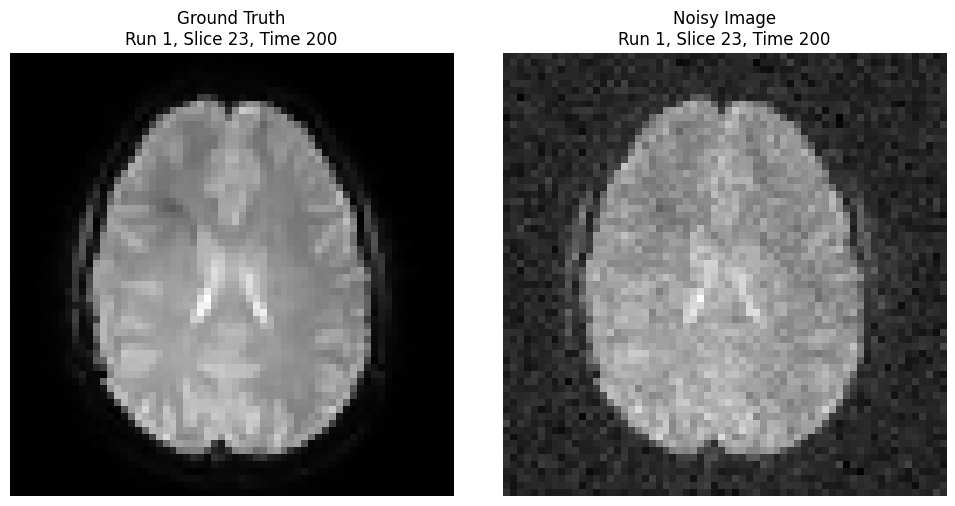

In [38]:
'Plot example slices'

# Choose slice and timeframe to plot
slice_index = 23
timeframe = 200

# Get run and corresponding slice within that run
run, slice_within_run = get_run_and_slice(slice_index)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth image
axes[0].imshow(data[:, :, slice_index, timeframe], cmap='gray')
axes[0].set_title(f'Ground Truth\nRun {run}, Slice {slice_within_run}, Time {timeframe}')
axes[0].axis("off")

# Plot noisy image
axes[1].imshow(noisy_data[:, :, slice_index, timeframe], cmap='gray')
axes[1].set_title(f'Noisy Image\nRun {run}, Slice {slice_within_run}, Time {timeframe}')
axes[1].axis("off")

# Show the plots
plt.tight_layout()
plt.show()

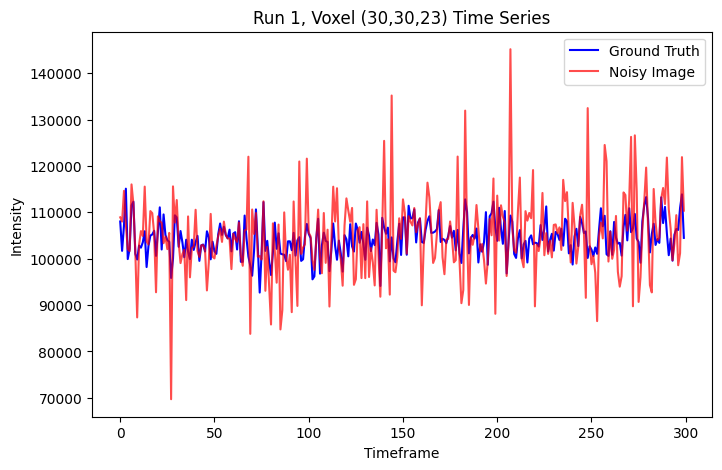

In [39]:
'Plot example voxel timeseries'

# Choose voxel and slice to plot time series
vx, vy = 30, 30

# Get run and corresponding slice within that run
run, slice_within_run = get_run_and_slice(slice_index)

# Create figure
plt.figure(figsize=(8, 5))

# Plot time series for ground truth and noisy data
plt.plot(data[vx, vy, slice_index, :], label="Ground Truth", color='b')
plt.plot(noisy_data[vx, vy, slice_index, :], label="Noisy Image", color='r', alpha=0.7)

# Add labels and title
plt.xlabel("Timeframe")
plt.ylabel("Intensity")
plt.title(f'Run {run}, Voxel ({vx},{vy},{slice_within_run}) Time Series')

# Add legend
plt.legend()

# Show plot
plt.show()

#3D-CNN-LSTM Model - Test Run Model

##1. Loading Dependencies

In [40]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM
import matplotlib.pyplot as plt
from tqdm import tqdm

##2. Data Loading & Preprocessing

In [41]:
data_folder = "/content/"
# loads and returns a NumPy array of shape (T, X, Y, Z)
clean_data = preprocess_nifti_data(data_folder)
np.save(f"{data_folder}/groundtruth_dataset.npy", clean_data)
noisy_data = add_gaussian_noise(clean_data, noise_level=0.1)
np.save(f"{data_folder}/noisy_dataset.npy", noisy_data)


Final shape of ground truth: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)
Final shape of noisy dataset: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [45]:
def pad_to_multiple_of_8(vol4d):
    # vol4d: np.ndarray with shape (T, X, Y, Z)
    T,X,Y,Z = vol4d.shape
    Yp = ((Y + 7)//8)*8
    Zp = ((Z + 7)//8)*8
    pad_y = Yp - Y
    pad_z = Zp - Z
    # pad ((before,after) for each axis: T,X,Y,Z)
    pads = [(0,0),(0,0),(0,pad_y),(0,pad_z)]
    return np.pad(vol4d, pads, mode='constant', constant_values=0)

# Example:
clean = np.load("groundtruth_dataset.npy")  # shape (T, X, Y, Z)
noisy = np.load("noisy_dataset.npy")        # same shape
clean_p = pad_to_multiple_of_8(clean)
noisy_p = pad_to_multiple_of_8(noisy)
np.save("groundtruth_padded.npy", clean_p)
np.save("noisy_padded.npy", noisy_p)


In [46]:
class FMRI_DenoiseDataset(Dataset):
    def __init__(self, noisy_path, clean_path, seq_len=20):
        self.noisy = np.load(noisy_path)   # (T, X, Y, Z)
        self.clean = np.load(clean_path)
        self.seq_len = seq_len

    def __len__(self):
        return self.noisy.shape[0] - self.seq_len

    def __getitem__(self, idx):
        n_seq = self.noisy[idx : idx + self.seq_len]   # (T, X, Y, Z)
        c_seq = self.clean[idx : idx + self.seq_len]
        # add *one* channel dim → (C=1, T, X, Y, Z)
        n_seq = torch.from_numpy(n_seq).unsqueeze(0).float()
        c_seq = torch.from_numpy(c_seq).unsqueeze(0).float()
        return n_seq, c_seq


##3. Modelling

###3.1. Model Architecture

In [47]:
# a) A simple 3D conv‐encoder
class Conv3dEncoder(nn.Module):
    def __init__(self, in_ch=1, feats=[16,32,64]):
        super().__init__()
        layers = []
        prev = in_ch
        for f in feats:
            layers += [
                nn.Conv3d(prev, f, 3, padding=1),
                nn.BatchNorm3d(f),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(2)
            ]
            prev = f
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# b) ConvLSTM cell over 3D features
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hide_ch, k=3):
        super().__init__()
        pad = k // 2
        self.conv = nn.Conv3d(in_ch + hide_ch, 4*hide_ch, k, padding=pad)
        self.hch = hide_ch

    def forward(self, x, h, c):
        # x,h,c : (B, C, X, Y, Z)
        cat = torch.cat([x, h], dim=1)
        i,f,g,o = torch.chunk(self.conv(cat), 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)
        return h_new, c_new

class ConvLSTM(nn.Module):
    def __init__(self, in_ch, hide_ch):
        super().__init__()
        self.cell = ConvLSTMCell(in_ch, hide_ch)

    def forward(self, seq):
        # seq: (B, C, T, X, Y, Z)
        B,C,T,X,Y,Z = seq.shape
        h = torch.zeros(B, self.cell.hch, X, Y, Z, device=seq.device)
        c = torch.zeros_like(h)
        outs = []
        for t in range(T):
            h, c = self.cell(seq[:,:,t], h, c)
            outs.append(h)
        return torch.stack(outs, dim=2)  # (B, hide_ch, T, X, Y, Z)

# c) A matching 3D conv‐decoder
class Conv3dDecoder(nn.Module):
    def __init__(self, feats=[64,32,16], out_ch=1):
        super().__init__()
        layers = []
        prev = feats[0]
        for f in feats[1:]:
            layers += [
                nn.ConvTranspose3d(prev, f, 2, stride=2),
                nn.BatchNorm3d(f),
                nn.ReLU(inplace=True)
            ]
            prev = f
        layers += [ nn.ConvTranspose3d(prev, out_ch, 2, stride=2) ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# d) Full denoiser model
class CNN_LSTM_Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Conv3dEncoder(1, [16,32,64])
        self.lstm = ConvLSTM(64, 64)
        self.dec = Conv3dDecoder([64,32,16], 1)

    def forward(self, seq):
        # seq: (B,1,T,X,Y,Z)
        B,_,T,X,Y,Z = seq.shape
        feats = [ self.enc(seq[:,:,t]) for t in range(T) ]
        feats = torch.stack(feats, dim=2)               # (B,64,T,X/8,Y/8,Z/8)
        temp = self.lstm(feats)                        # same shape
        outs = [ self.dec(temp[:,:,t]) for t in range(T) ]
        return torch.stack(outs, dim=2)                # (B,1,T,X,Y,Z)


###3.2. Training & Evaluation Loop

In [51]:
# —————— HYPERPARAMS & SETUP ——————
seq_len, batch_sz, lr, epochs = 20, 1, 1e-4, 30
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume FMRI_DenoiseDataset and CNN_LSTM_Denoiser are defined above…
ds        = FMRI_DenoiseDataset("noisy_padded.npy", "groundtruth_padded.npy", seq_len)
train_ds, val_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds)-int(0.8*len(ds))])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_sz, shuffle=False)

model     = CNN_LSTM_Denoiser().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

best_psnr = 0.0

# —————— TRAIN + VALID LOOP ——————
for ep in range(1, epochs+1):
    model.train()
    for noisy, clean in train_loader:
        noisy = noisy.to(device)   # (B,1,T,X,Y_gt,Z_gt)
        clean = clean.to(device)

        # 1) Forward & debug‐print
        out = model(noisy)         # (B,1,T,X,Y_out,Z_out)
        if ep == 1:
            print(f"\n>>> TRAIN EPOCH {ep}")
            print(f"  noisy.shape = {tuple(noisy.shape)}, dtype={noisy.dtype},   "
                  f"range=({noisy.min().item():.1f},{noisy.max().item():.1f})")
            print(f"  out.shape   = {tuple(out.shape)}, dtype={out.dtype},   "
                  f"range=({out.min().item():.1f},{out.max().item():.1f})")
            print(f"  clean.shape = {tuple(clean.shape)}, dtype={clean.dtype},   "
                  f"range=({clean.min().item():.1f},{clean.max().item():.1f})")

        # 2) Crop to match the clean volume’s spatial size
        _,_,_, Xc, Yc, Zc = clean.shape
        out = out[..., :Xc, :Yc, :Zc]

        # 3) Backprop
        loss = criterion(out, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ========= VALIDATION (fixed) =========
model.eval()
val_psnr = 0.0
val_ssim = 0.0
count    = 0

with torch.no_grad():
    for noisy, clean in val_loader:
        noisy = noisy.to(device)              # shape (B,1,T,X,Y,Z)
        clean = clean.to(device)

        # forward + crop (if you still need cropping):
        out = model(noisy)
        # out has shape (B,1,T,X,Y,Z) like clean
        # if you padded and want to un-pad back to match clean:
        # out = out[..., :clean.shape[3], :clean.shape[4], :clean.shape[5]]

        # ---- convert to NumPy and remove B & C dims ----
        est_np = out.cpu().numpy()    # (B,1,T,X,Y,Z)
        tgt_np = clean.cpu().numpy()  # (B,1,T,X,Y,Z)
        # remove batch & channel dims:
        est_np = est_np.squeeze(0).squeeze(0)  # now (T,X,Y,Z)
        tgt_np = tgt_np.squeeze(0).squeeze(0)  # now (T,X,Y,Z)

        # pull out dimensions
        T, X, Y, Z = tgt_np.shape

        # debug‐print once if you like:
        if ep == 1:
            print(f"\n>>> VALIDATION EPOCH {ep}")
            print(" est_np.shape =", est_np.shape,
                  "tgt_np.shape =", tgt_np.shape)

        # compute metrics
        for t in range(T):
            vol_true = tgt_np[t]   # (X,Y,Z)
            vol_est  = est_np[t]   # (X,Y,Z)

            # PSNR: explicitly pass the dynamic range
            data_range = vol_true.max() - vol_true.min()
            val_psnr += PSNR(vol_true, vol_est, data_range=data_range)

            # SSIM: skimage only does 2D, so average over all Z-slices
            ssim_vals = []
            for z in range(Z):
                ssim_vals.append(
                    SSIM(vol_true[:, :, z],
                         vol_est[:,  : , z],
                         data_range=data_range)
                )
            val_ssim += np.mean(ssim_vals)
            count   += 1

# finalize
val_psnr /= count
val_ssim /= count
print(f"Epoch {ep}: Val PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

# save best
if val_psnr > best_psnr:
    best_psnr = val_psnr
    torch.save(model.state_dict(), "best_model.pth")
    print("  ➜ saved new best_model.pth\n")


>>> TRAIN EPOCH 1
  noisy.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-81277.1,234742.8)
  out.shape   = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-3.7,4.3)
  clean.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(0.0,201143.0)

>>> TRAIN EPOCH 1
  noisy.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-81277.1,250760.4)
  out.shape   = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-3.6,5.3)
  clean.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(0.0,201143.0)

>>> TRAIN EPOCH 1
  noisy.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-75063.9,201138.5)
  out.shape   = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-4.2,6.0)
  clean.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(0.0,169412.0)

>>> TRAIN EPOCH 1
  noisy.shape = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   range=(-81277.1,205246.0)
  out.shape   = (1, 1, 20, 64, 40, 304), dtype=torch.float32,   ra

##3.3. Visualisation

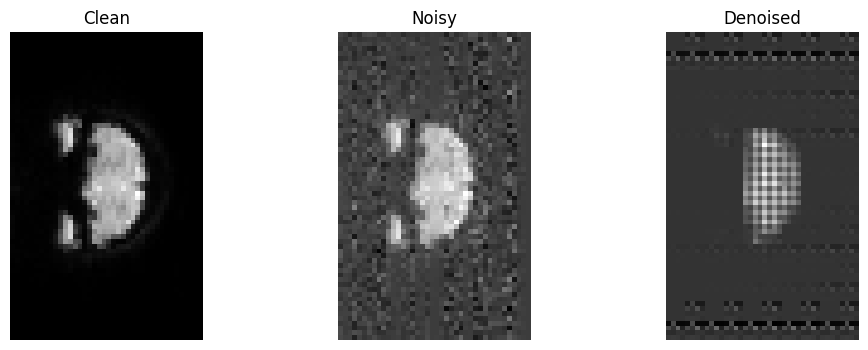

In [52]:
import matplotlib.pyplot as plt

# load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# grab one sequence from the dataset
noisy_seq, clean_seq = ds[0]
noisy_tensor = noisy_seq.to(device).unsqueeze(0)  # add batch dim
with torch.no_grad():
    den_seq = model(noisy_tensor).cpu().squeeze().numpy()  # (T,X,Y,Z)

t_sel = seq_len // 2
slice_sel = 23

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(clean_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Clean")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Noisy")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(den_seq[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Denoised")
plt.axis("off")
plt.show()


##3.4. Saving the Test-Run Model

In [53]:
torch.save(model.state_dict(), "cnn_lstm_denoiser_v0.pth")

#3D-CNN-LSTM - Tuning Sprint 1

[3D-CNN Encoder] → [ConvLSTM Bottleneck] → [3D-CNN Decoder]

1. Normalize each sequence to 0,1 in the Dataset
2. Train as a residual model

##1. Loading Dependencies

In [54]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM
import matplotlib.pyplot as plt
from tqdm import tqdm

##2. Data Loading & Preprocessing

In [ ]:
data_folder = "/content/"
# loads and returns a NumPy array of shape (T, X, Y, Z)
clean_data = preprocess_nifti_data(data_folder)
np.save(f"{data_folder}/groundtruth_dataset.npy", clean_data)
noisy_data = add_gaussian_noise(clean_data, noise_level=0.1)
np.save(f"{data_folder}/noisy_dataset.npy", noisy_data)


Final shape of ground truth: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)
Final shape of noisy dataset: (64, 64, 39, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [ ]:
def pad_to_multiple_of_8(vol4d):
    # vol4d: np.ndarray with shape (T, X, Y, Z)
    T,X,Y,Z = vol4d.shape
    Yp = ((Y + 7)//8)*8
    Zp = ((Z + 7)//8)*8
    pad_y = Yp - Y
    pad_z = Zp - Z
    # pad ((before,after) for each axis: T,X,Y,Z)
    pads = [(0,0),(0,0),(0,pad_y),(0,pad_z)]
    return np.pad(vol4d, pads, mode='constant', constant_values=0)

# Example:
clean = np.load("groundtruth_dataset.npy")  # shape (T, X, Y, Z)
noisy = np.load("noisy_dataset.npy")        # same shape
clean_p = pad_to_multiple_of_8(clean)
noisy_p = pad_to_multiple_of_8(noisy)
np.save("groundtruth_padded.npy", clean_p)
np.save("noisy_padded.npy", noisy_p)


In [55]:
class FMRI_DenoiseDataset(Dataset):
    def __init__(self, noisy_path, clean_path, seq_len=20):
        self.noisy = np.load(noisy_path)   # (T, X, Y, Z)
        self.clean = np.load(clean_path)
        self.seq_len = seq_len

    def __len__(self):
        return self.noisy.shape[0] - self.seq_len

    def __getitem__(self, idx):
        # slice out a T‐length chunk
        n_seq = self.noisy[idx : idx + self.seq_len]   # (T, X, Y, Z)
        c_seq = self.clean[idx : idx + self.seq_len]

        # add channel dim → (1, T, X, Y, Z)
        n_seq = torch.from_numpy(n_seq).unsqueeze(0).float()
        c_seq = torch.from_numpy(c_seq).unsqueeze(0).float()

        # per‐sequence min/max (on the noisy input)
        mn = n_seq.min()
        mx = n_seq.max()
        n_seq = (n_seq - mn) / (mx - mn + 1e-6)
        c_seq = (c_seq - mn) / (mx - mn + 1e-6)

        return n_seq, c_seq


##3. Modelling

###3.1. Model Architecture

In [56]:
# a) A simple 3D conv‐encoder
class Conv3dEncoder(nn.Module):
    def __init__(self, in_ch=1, feats=[16,32,64]):
        super().__init__()
        layers = []
        prev = in_ch
        for f in feats:
            layers += [
                nn.Conv3d(prev, f, 3, padding=1),
                nn.BatchNorm3d(f),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(2)
            ]
            prev = f
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# b) ConvLSTM cell over 3D features
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hide_ch, k=3):
        super().__init__()
        pad = k // 2
        self.conv = nn.Conv3d(in_ch + hide_ch, 4*hide_ch, k, padding=pad)
        self.hch = hide_ch

    def forward(self, x, h, c):
        # x,h,c : (B, C, X, Y, Z)
        cat = torch.cat([x, h], dim=1)
        i,f,g,o = torch.chunk(self.conv(cat), 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)
        return h_new, c_new

class ConvLSTM(nn.Module):
    def __init__(self, in_ch, hide_ch):
        super().__init__()
        self.cell = ConvLSTMCell(in_ch, hide_ch)

    def forward(self, seq):
        # seq: (B, C, T, X, Y, Z)
        B,C,T,X,Y,Z = seq.shape
        h = torch.zeros(B, self.cell.hch, X, Y, Z, device=seq.device)
        c = torch.zeros_like(h)
        outs = []
        for t in range(T):
            h, c = self.cell(seq[:,:,t], h, c)
            outs.append(h)
        return torch.stack(outs, dim=2)  # (B, hide_ch, T, X, Y, Z)

# c) A matching 3D conv‐decoder
class Conv3dDecoder(nn.Module):
    def __init__(self, feats=[64,32,16], out_ch=1):
        super().__init__()
        layers = []
        prev = feats[0]
        for f in feats[1:]:
            layers += [
                nn.ConvTranspose3d(prev, f, 2, stride=2),
                nn.BatchNorm3d(f),
                nn.ReLU(inplace=True)
            ]
            prev = f
        layers += [ nn.ConvTranspose3d(prev, out_ch, 2, stride=2) ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# d) Full denoiser model
class CNN_LSTM_Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Conv3dEncoder(1, [16,32,64])
        self.lstm = ConvLSTM(64, 64)
        self.dec = Conv3dDecoder([64,32,16], 1)

    def forward(self, seq):
        # seq: (B,1,T,X,Y,Z)
        B,_,T,X,Y,Z = seq.shape
        feats = [ self.enc(seq[:,:,t]) for t in range(T) ]
        feats = torch.stack(feats, dim=2)               # (B,64,T,X/8,Y/8,Z/8)
        temp = self.lstm(feats)                        # same shape
        outs = [ self.dec(temp[:,:,t]) for t in range(T) ]
        return torch.stack(outs, dim=2)                # (B,1,T,X,Y,Z)


###3.2. Training & Evaluation Loop

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity      as SSIM

# —————— HYPERPARAMS & SETUP ——————
seq_len, batch_sz, lr, epochs = 20, 1, 1e-4, 30
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & Loaders (you’ve already implemented per-sequence normalization)
ds        = FMRI_DenoiseDataset("noisy_padded.npy", "groundtruth_padded.npy", seq_len)
train_ds, val_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds)-int(0.8*len(ds))])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_sz, shuffle=False)

# Model, Loss, Optimizer
model     = CNN_LSTM_Denoiser().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

best_psnr = 0.0

# —————— TRAIN + VALID LOOP ——————
for ep in range(1, epochs+1):
    model.train()
    for noisy, clean in train_loader:
        # Move to GPU/CPU
        noisy = noisy.to(device)   # shape: (B,1,T,X,Y,Z)
        clean = clean.to(device)

        # Forward → predict the NOISE
        noise_pred = model(noisy)   # same shape
        # Residual: subtract from the input to get the clean estimate
        clean_est  = noisy - noise_pred

        # Crop in case you padded spatial dims
        _,_,_, Xc, Yc, Zc = clean.shape
        clean_est = clean_est[..., :Xc, :Yc, :Zc]

        # Compute loss on the clean estimate
        loss = criterion(clean_est, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ——— VALIDATION ———
    model.eval()
    val_psnr, val_ssim, count = 0.0, 0.0, 0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            # Forward & residual
            noise_pred = model(noisy)
            clean_est  = noisy - noise_pred
            clean_est  = clean_est[..., :clean.shape[3], :clean.shape[4], :clean.shape[5]]

            # To NumPy and squeeze out B & C dims → (T,X,Y,Z)
            est_np = clean_est.cpu().numpy().squeeze(0).squeeze(0)
            tgt_np = clean.cpu().numpy().squeeze(0).squeeze(0)
            T, X, Y, Z = tgt_np.shape

            # Compute PSNR and SSIM per timepoint
            for t in range(T):
                vol_true = tgt_np[t]
                vol_est  = est_np[t]
                dr = vol_true.max() - vol_true.min()

                val_psnr += PSNR(vol_true, vol_est, data_range=dr)

                # slice‐wise SSIM
                ssim_vals = [
                    SSIM(vol_true[:,:,z], vol_est[:,:,z], data_range=dr)
                    for z in range(Z)
                ]
                val_ssim += np.mean(ssim_vals)
                count    += 1

    val_psnr /= count
    val_ssim /= count
    print(f"Epoch {ep}: Val PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    # Save best
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), "cnn_lstm_denoiser_residual_v1.pth")
        print("  ➜ saved cnn_lstm_denoiser_residual_v1.pth\n")

Epoch 1: Val PSNR = 2.58, SSIM = 0.0511
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 2: Val PSNR = 4.45, SSIM = 0.0772
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 3: Val PSNR = 6.48, SSIM = 0.1155
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 4: Val PSNR = 8.59, SSIM = 0.1620
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 5: Val PSNR = 10.65, SSIM = 0.2174
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 6: Val PSNR = 12.52, SSIM = 0.2713
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 7: Val PSNR = 14.02, SSIM = 0.3145
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 8: Val PSNR = 15.24, SSIM = 0.3506
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 9: Val PSNR = 16.24, SSIM = 0.3801
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 10: Val PSNR = 17.14, SSIM = 0.4086
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 11: Val PSNR = 17.88, SSIM = 0.4317
  ➜ saved cnn_lstm_denoiser_residual_v1.pth

Epoch 12: Val PSNR = 18.54, SSIM = 0.4523
  ➜ saved cnn_

##3.3. Visualisation

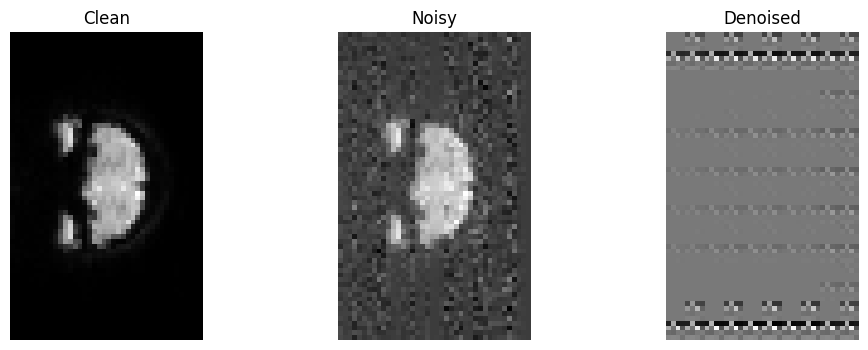

In [58]:
import matplotlib.pyplot as plt

# load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# grab one sequence from the dataset
noisy_seq, clean_seq = ds[0]
noisy_tensor = noisy_seq.to(device).unsqueeze(0)  # add batch dim
with torch.no_grad():
    den_seq = model(noisy_tensor).cpu().squeeze().numpy()  # (T,X,Y,Z)

t_sel = seq_len // 2
slice_sel = 23

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(clean_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Clean")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Noisy")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(den_seq[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Denoised")
plt.axis("off")
plt.show()


##3.4. Saving the Test-Run Model

In [ ]:
torch.save(model.state_dict(), "cnn_lstm_denoiser_v0.pth")

#3D-CNN-LSTM - Tuning Sprint 2

1. Add UNet-style skip connections (still 3D-CNN-LSTM)
2. Add an SSIM term to your loss


##3. Modelling

###3.1. Model Architecture

In [63]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [59]:
import torch
import torch.nn as nn

# A tiny 3D Conv block: Conv3d→BN→ReLU
class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class CNN_LSTM_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock3D(1,  16)   # → (B,16,X,Y,Z)
        self.pool = nn.MaxPool3d(2)       # halves each spatial dim
        self.enc2 = ConvBlock3D(16, 32)   # → (B,32,X/2,Y/2,Z/2)
        self.enc3 = ConvBlock3D(32, 64)   # → (B,64,X/4,Y/4,Z/4)

        # ConvLSTM bottleneck (re-uses your existing ConvLSTMCell/ConvLSTM)
        self.lstm = ConvLSTM(64, 64)      # input+hidden = 64 channels

        # Decoder
        # up3: 64→32, then concat skip2 (32) → 64→32
        self.up3  = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec3 = ConvBlock3D(32 + 32, 32)

        # up2: 32→16, then concat skip1 (16) → 32→16
        self.up2  = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.dec2 = ConvBlock3D(16 + 16, 16)

        # final conv: 16→1 to predict the **noise**
        self.final = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, seq):
        """
        seq: (B,1,T,X,Y,Z)
        returns noise_pred of shape (B,1,T,X,Y,Z)
        """
        B, C, T, X, Y, Z = seq.shape

        # 1) Encode each timepoint, saving skips
        skips1, skips2, feats = [], [], []
        for t in range(T):
            x = self.enc1(seq[:, :, t])   # (B,16,X,Y,Z)
            skips1.append(x)
            x = self.pool(x)              # (B,16,X/2,Y/2,Z/2)
            x = self.enc2(x)              # (B,32,X/2,Y/2,Z/2)
            skips2.append(x)
            x = self.pool(x)              # (B,32,X/4,Y/4,Z/4)
            x = self.enc3(x)              # (B,64,X/4,Y/4,Z/4)
            feats.append(x)

        # stack over time: (B,64,T,X/4,Y/4,Z/4)
        feats = torch.stack(feats, dim=2)
        # ConvLSTM → same shape
        lstm_out = self.lstm(feats)

        # 2) Decode each time step with skip‐links
        outs = []
        for t in range(T):
            x = lstm_out[:, :, t]             # (B,64,X/4,Y/4,Z/4)

            # up & skip from enc3→enc2
            x = self.up3(x)                   # (B,32,X/2,Y/2,Z/2)
            x = torch.cat([x, skips2[t]], 1)  # (B,64,X/2,Y/2,Z/2)
            x = self.dec3(x)                  # (B,32,X/2,Y/2,Z/2)

            # up & skip from enc2→enc1
            x = self.up2(x)                   # (B,16,X,Y,Z)
            x = torch.cat([x, skips1[t]], 1)  # (B,32,X,Y,Z)
            x = self.dec2(x)                  # (B,16,X,Y,Z)

            # final 1×1 conv → noise prediction
            noise_pred = self.final(x)        # (B,1,X,Y,Z)
            outs.append(noise_pred)

        # stack back to (B,1,T,X,Y,Z)
        return torch.stack(outs, dim=2)


###3.2. Training & Evaluation Loop

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity      as SSIM
from pytorch_msssim import ssim

# —————— HYPERPARAMS & SETUP ——————
seq_len, batch_sz, lr, epochs = 20, 1, 1e-4, 30
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & Loaders (you’ve already implemented per-sequence normalization)
ds        = FMRI_DenoiseDataset("noisy_padded.npy", "groundtruth_padded.npy", seq_len)
train_ds, val_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds)-int(0.8*len(ds))])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_sz, shuffle=False)

# Model, Loss, Optimizer
model = CNN_LSTM_UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

def combined_loss(clean_est, clean):
    # MSE + SSIM
    mse_l = nn.MSELoss()(clean_est, clean)
    ssim_vals = []
    for t in range(clean.shape[2]):
        ssim_vals.append( ssim(clean_est[:,:,t], clean[:,:,t], data_range=1.0) )
    ssim_l = torch.stack(ssim_vals).mean()
    return mse_l + 0.5*(1 - ssim_l)

def temporal_loss(clean_est):
    diffs = clean_est[:,:,1:] - clean_est[:,:,:-1]
    return diffs.abs().mean()

best_psnr = 0.0

# —————— TRAIN + VALID LOOP ——————
for ep in range(1, epochs+1):
    model.train()
    for noisy, clean in train_loader:
        # Move to GPU/CPU
        noisy = noisy.to(device)   # shape: (B,1,T,X,Y,Z)
        clean = clean.to(device)

        # Forward → predict the NOISE
        noise_pred = model(noisy)   # same shape
        # Residual: subtract from the input to get the clean estimate
        clean_est  = noisy - noise_pred

        # Crop in case you padded spatial dims
        _,_,_, Xc, Yc, Zc = clean.shape
        clean_est = clean_est[..., :Xc, :Yc, :Zc]

        # Compute loss on the clean estimate
        loss = combined_loss(clean_est, clean) + 0.1*temporal_loss(clean_est)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # ——— VALIDATION ———
    model.eval()
    val_psnr, val_ssim, count = 0.0, 0.0, 0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            # Forward & residual
            noise_pred = model(noisy)
            clean_est  = noisy - noise_pred
            clean_est  = clean_est[..., :clean.shape[3], :clean.shape[4], :clean.shape[5]]

            # To NumPy and squeeze out B & C dims → (T,X,Y,Z)
            est_np = clean_est.cpu().numpy().squeeze(0).squeeze(0)
            tgt_np = clean.cpu().numpy().squeeze(0).squeeze(0)
            T, X, Y, Z = tgt_np.shape

            # Compute PSNR and SSIM per timepoint
            for t in range(T):
                vol_true = tgt_np[t]
                vol_est  = est_np[t]
                dr = vol_true.max() - vol_true.min()

                val_psnr += PSNR(vol_true, vol_est, data_range=dr)

                # slice‐wise SSIM
                ssim_vals = [
                    SSIM(vol_true[:,:,z], vol_est[:,:,z], data_range=dr)
                    for z in range(Z)
                ]
                val_ssim += np.mean(ssim_vals)
                count    += 1

    val_psnr /= count
    val_ssim /= count
    print(f"Epoch {ep}: Val PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    # Save best
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), "cnn_lstm_denoiser_residual_v1.pth")
        print("  ➜ saved cnn_lstm_denoiser_residual_v1.pth\n")

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 42.12 MiB is free. Process 11877 has 14.70 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 142.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

##3.3. Visualisation

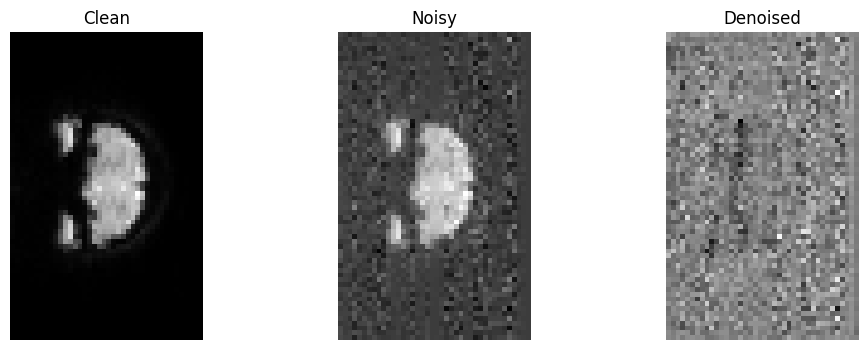

In [62]:
import matplotlib.pyplot as plt

# load best model
model.load_state_dict(torch.load("cnn_lstm_denoiser_residual_v1.pth"))
model.eval()

# grab one sequence from the dataset
noisy_seq, clean_seq = ds[0]
noisy_tensor = noisy_seq.to(device).unsqueeze(0)  # add batch dim
with torch.no_grad():
    den_seq = model(noisy_tensor).cpu().squeeze().numpy()  # (T,X,Y,Z)

t_sel = seq_len // 2
slice_sel = 23

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(clean_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Clean")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy_seq.squeeze()[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Noisy")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(den_seq[t_sel,:,:,slice_sel], cmap="gray")
plt.title("Denoised")
plt.axis("off")
plt.show()


##3.4. Saving the Test-Run Model

In [ ]:
torch.save(model.state_dict(), "cnn_lstm_denoiser_v0.pth")